# 로지스틱 회귀

## 문제 해결을 위한 데이터셋 준비

1. 필요한 패키기 불러오기


In [1]:
import random
import torch 
import torch.nn as nn 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

2. 데이터셋 불러오기

In [2]:
cancer = load_breast_cancer()
print(cancer.data.shape, cancer.target.shape)
type(cancer)

(569, 30) (569,)


sklearn.utils.Bunch

In [3]:
raw_dataset = pd.DataFrame(cancer.data)
dataset_df= raw_dataset.copy()
# dataset_df['target'] = cancer.target
dataset_df = dataset_df.dropna()
dataset_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


3. 데이터 확인하기 

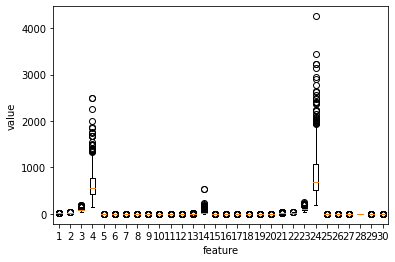

In [4]:
plt.boxplot(cancer.data)
plt.xlabel("feature")
plt.ylabel("value")
plt.show()

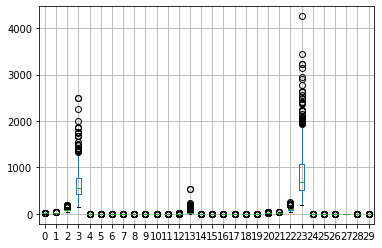

In [5]:
dataset_df.boxplot()

In [6]:
dataset_df = dataset_df.drop(columns=[3,13,23])

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(dataset_df)
dataset_scaled = scaler.transform(dataset_df)
df_dataset_scaled = pd.DataFrame(data=dataset_scaled, columns=dataset_df.columns)

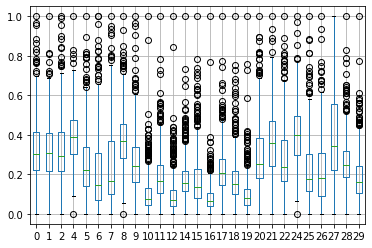

In [8]:
df_dataset_scaled.boxplot()

4. 학습 데이터셋 준비

In [9]:
x = df_dataset_scaled.to_numpy()
y = cancer.target 

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)  # 수정 금지 
x_train, x_eval, y_train, y_eval = train_test_split(x_train, y_train, stratify=y_train, test_size=0.125, random_state=999)

x_train_torch = torch.FloatTensor(x_train)
y_train_torch = torch.FloatTensor(y_train)
x_eval_torch = torch.FloatTensor(x_eval)
y_eval_torch = torch.FloatTensor(y_eval) 
x_test_torch = torch.FloatTensor(x_test)
y_test_torch = torch.FloatTensor(y_test)

In [10]:
print(np.shape(x))

(569, 27)


In [11]:
print(np.shape(y))

(569,)


5. 모델 준비

In [12]:
class LogisticNeuron(nn.Module):
  def __init__(self, in_dim=30, n_hidden=60, learning_rate=1e-4):
    '''
    Args:
      in_dim: The dimension of input data  
      n_hidden: The dimension of hidden layer
      learning_rate: The initial learning rate for training a network 
    '''
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(in_dim, n_hidden),
        nn.ReLU(), 
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(), 
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, 1),
        nn.Sigmoid()
        )
    
    self.optim = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
    self.criterion = nn.BCELoss()

  def _calculate_loss(self, x, y):
    loss = self.criterion(x, y)
    return loss 

  def forward(self, x):
    z = self.model(x)
    return z

  def train(self, x, y, epochs=10):
    tmp_acc = -1
    for i in range(epochs):
      for x_i, y_i in zip(x, y):
        pred_y = self.forward(x_i)
        loss = self._calculate_loss(pred_y[0], y_i)
        self.model.zero_grad() 
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()

      if (i+1) % 10 == 0:  # 여기 나누는 값을 조정해서 프린트하는 횟수를 조절
        acc = np.mean(self.predict(x_eval_torch) == y_eval)
        if tmp_acc == -1: 
          tmp_acc = acc 
        if tmp_acc > acc:
          break
        print("epoch {} : err = {:.4f}, eval acc = {:%}".format(i + 1, loss, acc))

  def predict(self, x):
    pred = [self.forward(x_i).data.numpy()[0] for x_i in x]
    return np.array(pred) > 0.5 

In [13]:
random_seed = 123
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

neuron = LogisticNeuron(in_dim=27, n_hidden=100, learning_rate=1e-4)
neuron.train(x_train_torch, y_train_torch,epochs=100)

epoch 10 : err = 0.0010, eval acc = 96.491228%
epoch 20 : err = 0.0002, eval acc = 96.491228%
epoch 30 : err = 0.0001, eval acc = 96.491228%
epoch 40 : err = 0.0001, eval acc = 96.491228%
epoch 50 : err = 0.0000, eval acc = 96.491228%
epoch 60 : err = 0.0000, eval acc = 96.491228%
epoch 70 : err = 0.0000, eval acc = 98.245614%
epoch 80 : err = 0.0000, eval acc = 98.245614%
epoch 90 : err = 0.0000, eval acc = 98.245614%
epoch 100 : err = 0.0000, eval acc = 96.491228%


6. 결과

In [14]:
np.mean(neuron.predict(x_test_torch) == y_test)

0.9736842105263158